# LAB 5: Morphological Image Processing and Image Segmentation

`Sabin Dahal (022bscit035)`

Morphological image processing uses operations like dilation and erosion to analyze and process shapes in binary or grayscale images, helping to remove noise, fill gaps, and extract structures. Image segmentation divides an image into meaningful regions or objects, enabling easier analysis and interpretation of image content.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read and resize two images to same size
img1 = cv2.imread('scenery.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('lab1/free-nature-images.jpg', cv2.IMREAD_GRAYSCALE)
img1 = cv2.resize(img1, (300, 300))
img2 = cv2.resize(img2, (300, 300))



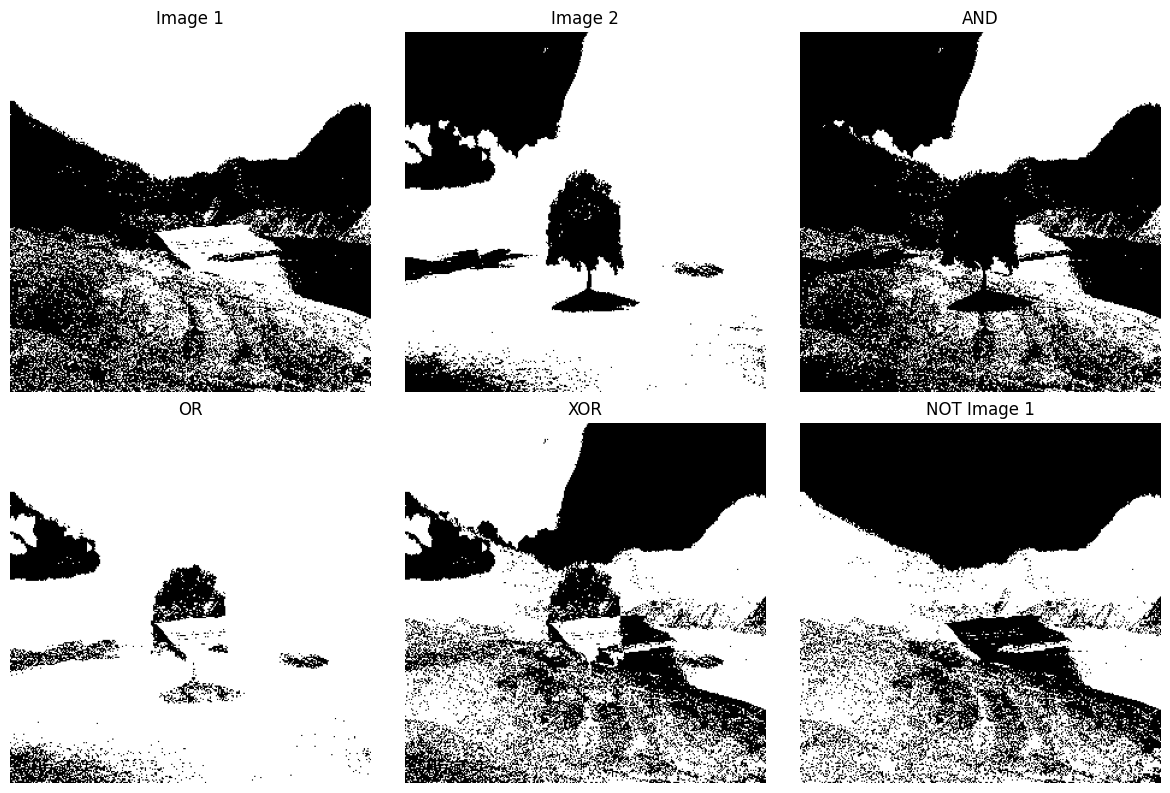

In [2]:
# Convert to binary (threshold)
_, bin1 = cv2.threshold(img1, 127, 255, cv2.THRESH_BINARY)
_, bin2 = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY)

# Perform logical operations
and_img = cv2.bitwise_and(bin1, bin2)
or_img  = cv2.bitwise_or(bin1, bin2)
xor_img = cv2.bitwise_xor(bin1, bin2)
not_img = cv2.bitwise_not(bin1)  # NOT on img1

# Plotting
titles = ['Image 1', 'Image 2', 'AND', 'OR', 'XOR', 'NOT Image 1']
images = [bin1, bin2, and_img, or_img, xor_img, not_img]

plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [3]:
_, binary = cv2.threshold(img1, 127, 255, cv2.THRESH_BINARY)
binary = binary // 255  # Convert to 0 and 1 for easy math

# Structuring element (3x3 square)
kernel = np.ones((3, 3), dtype=np.uint8)
k_h, k_w = kernel.shape
pad_h, pad_w = k_h // 2, k_w // 2



In [4]:
def dilation(image, kernel):
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i+k_h, j:j+k_w]
            output[i, j] = 1 if np.any(region * kernel) else 0
    return output

In [5]:
def erosion(image, kernel):
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i+k_h, j:j+k_w]
            output[i, j] = 1 if np.all(region[kernel == 1] == 1) else 0
    return output



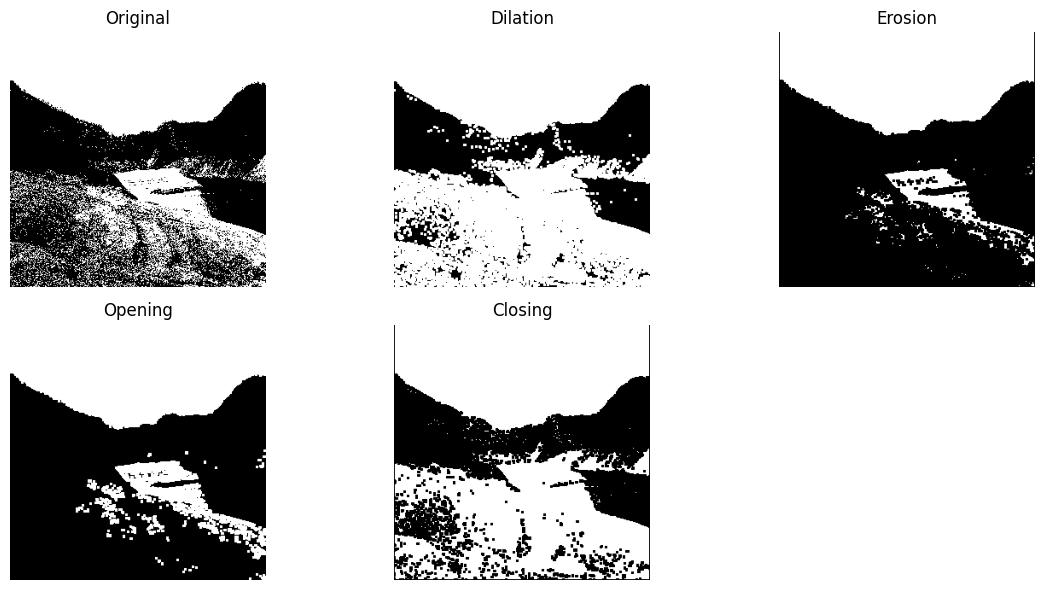

In [6]:
def opening(image, kernel):
    return dilation(erosion(image, kernel), kernel)

def closing(image, kernel):
    return erosion(dilation(image, kernel), kernel)

# Perform operations
dilated = dilation(binary, kernel)
eroded = erosion(binary, kernel)
opened = opening(binary, kernel)
closed = closing(binary, kernel)

# Convert back to 0-255 for display
images = [binary * 255, dilated * 255, eroded * 255, opened * 255, closed * 255]
titles = ['Original', 'Dilation', 'Erosion', 'Opening', 'Closing']

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
def hough_lines(img):
    height, width = img.shape
    diag_len = int(np.ceil(np.sqrt(height**2 + width**2)))
    rhos = np.arange(-diag_len, diag_len + 1, 1)
    thetas = np.deg2rad(np.arange(-90, 90, 1))

    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    maxIntersection = 0
    y_idxs, x_idxs = np.nonzero(img)

    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for theta_idx in range(len(thetas)):
            theta = thetas[theta_idx]
            rho = int(round(x * np.cos(theta) + y * np.sin(theta)) + diag_len)
            accumulator[rho, theta_idx] += 1
            maxIntersection = max(maxIntersection, accumulator[rho, theta_idx])

    return accumulator, thetas, rhos, maxIntersection

In [8]:
def drawLines(img, accumulator, thetas, rhos, threshold):
    temp = img.copy()
    for i in range(len(accumulator)):
        for j in range(len(accumulator[0])):
            if accumulator[i][j] < threshold: continue
            rho = rhos[i]
            theta = thetas[j]

            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho

            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))

            cv2.line(temp, (x1, y1), (x2, y2), 127)
    return temp


(851, 180)


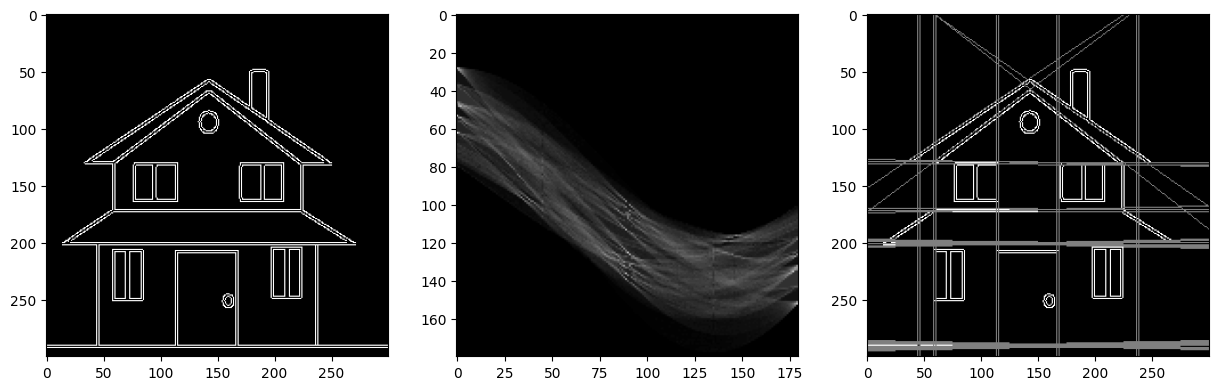

In [9]:
imgFeed = cv2.resize(cv2.imread('house.png'), (300, 300), interpolation=cv2.INTER_LINEAR)
imgFeed = cv2.Canny(imgFeed, threshold1=100, threshold2=200)

accumulator, thetas, rhos, maxIntersection = hough_lines(imgFeed)
# print(accumulator, thetas, rhos)
linesImage = drawLines(imgFeed, accumulator, thetas, rhos, 90)
print(accumulator.shape)

accumulator = (accumulator * 256) // maxIntersection
accumulator = cv2.resize(accumulator.astype(np.uint8), (180, 180))

plt.figure(figsize=(15,6))
plt.subplot(1, 3, 1)
plt.imshow(imgFeed, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(accumulator, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(linesImage, cmap='gray')

In [10]:
def threshold_segmentation(img, thresh_val=127):
    _, binary = cv2.threshold(img, thresh_val, 255, cv2.THRESH_BINARY)
    return binary

In [11]:
def region_growing(img, seed, threshold=5):
    height, width = img.shape
    segmented = np.zeros_like(img)
    visited = np.zeros_like(img, dtype=bool)
    
    seed_val = img[seed]
    stack = [seed]

    while stack:
        x, y = stack.pop()
        if visited[x, y]:
            continue
        visited[x, y] = True

        if abs(int(img[x, y]) - int(seed_val)) < threshold:
            segmented[x, y] = 255
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < height and 0 <= ny < width and not visited[nx, ny]:
                        stack.append((nx, ny))
    return segmented


In [12]:
def split(img, min_size=16, std_thresh=15):
    h, w = img.shape
    segmented = np.zeros_like(img)

    def split_rec(x, y, width, height):
        region = img[y:y+height, x:x+width]
        if region.size == 0:
            return
        std = np.std(region)
        if std < std_thresh or width <= min_size or height <= min_size:
            segmented[y:y+height, x:x+width] = np.mean(region)
        else:
            half_w, half_h = width // 2, height // 2
            split_rec(x, y, half_w, half_h)
            split_rec(x + half_w, y, width - half_w, half_h)
            split_rec(x, y + half_h, half_w, height - half_h)
            split_rec(x + half_w, y + half_h, width - half_w, height - half_h)
    split_rec(0, 0, w, h)
    return segmented


In [13]:
def merge_regions(segmented, similarity_thresh=10):
    # Very basic merging of neighboring pixels with close intensity
    h, w = segmented.shape
    merged = segmented.copy()

    for y in range(1, h - 1):
        for x in range(1, w - 1):
            neighbors = segmented[y-1:y+2, x-1:x+2].flatten()
            avg = np.mean(neighbors)
            if np.abs(segmented[y, x] - avg) < similarity_thresh:
                merged[y, x] = avg
    return merged


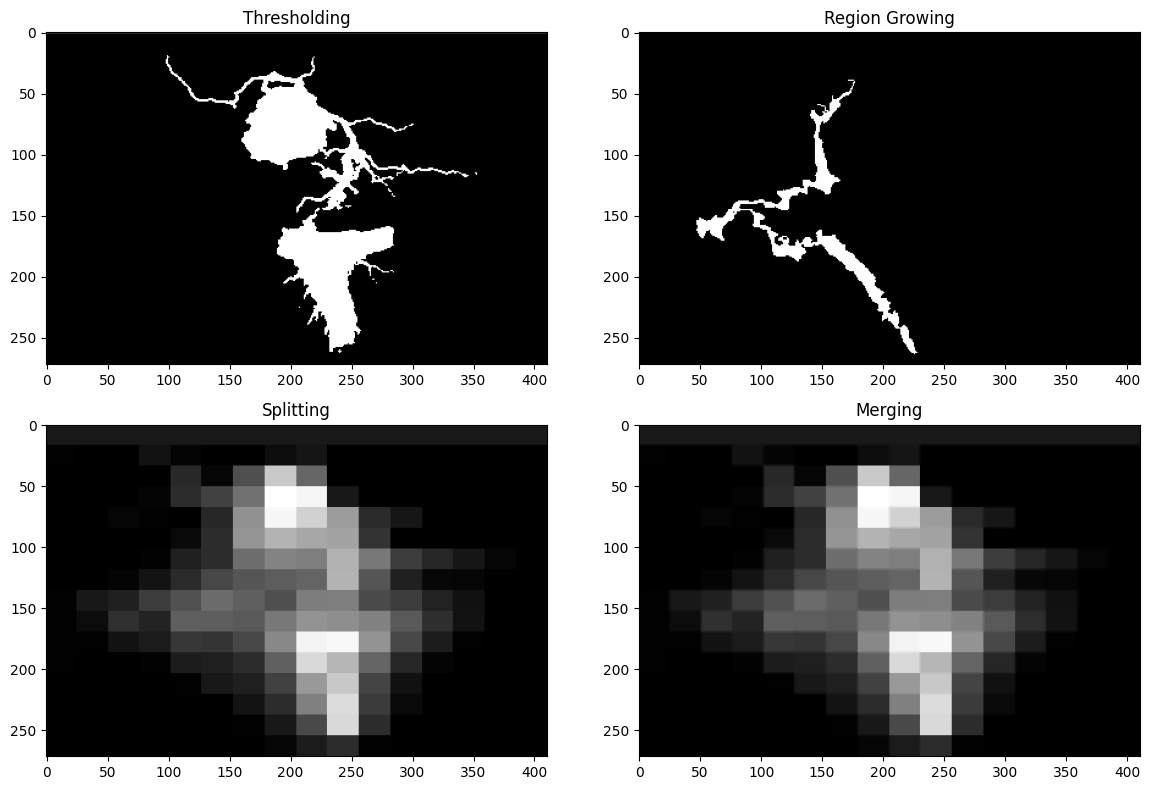

In [14]:
img = cv2.imread('lightning.png', 0)

# Thresholding
thresh_img = threshold_segmentation(img, 100)

# Region Growing (click seed manually)
seed = (100, 150)
region_img = region_growing(img, seed, threshold=10)

# Splitting and Merging
split_img = split(img,32,2)
merged_img = merge_regions(split_img)

# Display
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1), plt.imshow(thresh_img, cmap='gray'), plt.title('Thresholding')
plt.subplot(2, 2, 2), plt.imshow(region_img, cmap='gray'), plt.title('Region Growing')
plt.subplot(2, 2, 3), plt.imshow(split_img, cmap='gray'), plt.title('Splitting')
plt.subplot(2, 2, 4), plt.imshow(merged_img, cmap='gray'), plt.title('Merging')
plt.tight_layout()
plt.show()
